# 데이터 준비


In [34]:
# !pip install pymysql
# !pip3 install feature-engine==1.1.2 scikit-learn==1.0.0 imbalanced-learn==0.8.1

import pandas as pd
from pandas import DataFrame

import numpy as np
import pymysql
from sklearn.preprocessing import MinMaxScaler
from feature_engine.encoding import OneHotEncoder
from imblearn.over_sampling import SMOTE

from xgboost import plot_importance, plot_tree
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns
import gc
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold



import lightgbm as lgb
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, RepeatVector


In [38]:
conn = pymysql.connect(
    host='172.18.0.2', 
    port=3306,
    user='root',
    passwd='insight2022',
    db='insight',
    charset='utf8',
    autocommit=False
)

cursor = conn.cursor(cursor=pymysql.cursors.DictCursor)


In [40]:
QUERY = """
        select * 
        from bike 
        where date 
        between '2022-05-13' and '2022-05-15' 
        limit 10;
            """

# for value in data:
cursor.execute(QUERY)
weather_data = cursor.fetchall()
weather_df = pd.DataFrame.from_dict(weather_data)

weather_df.head()



,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date
0,2329302,15,32,213,ST-4,2022-05-13 00:00:02
1,2329303,14,28,200,ST-5,2022-05-13 00:00:02
2,2329304,13,0,0,ST-6,2022-05-13 00:00:02
3,2329305,5,1,20,ST-7,2022-05-13 00:00:02
4,2329306,12,1,8,ST-8,2022-05-13 00:00:02


In [3]:
w_QUERY = "select * from weather where date between '2022-05-13' and '2022-05-15';"
b_QUERY = "select * from bike where date between '2022-05-13' and '2022-05-15';"

In [4]:
conn = pymysql.connect(
    host='172.18.0.2', 
    port=3306,
    user='root',
    passwd='insight2022',
    db='insight',
    charset='utf8',
    autocommit=False
)

cursor = conn.cursor(cursor=pymysql.cursors.DictCursor)

# for value in data:
cursor.execute(w_QUERY)
weather_data = cursor.fetchall()
weather_df = pd.DataFrame.from_dict(weather_data)

cursor.execute(b_QUERY)
bike_data = cursor.fetchall() # list of dictionary
bike_df = pd.DataFrame.from_dict(bike_data)

# conn.commit()
cursor.close()
conn.close()


In [5]:
bike_df.tail()

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date
1488955,3818257,10,9,90,ST-3031,2022-05-14 23:55:02
1488956,3818258,4,1,25,ST-3015,2022-05-14 23:55:02
1488957,3818259,15,5,33,ST-3040,2022-05-14 23:55:02
1488958,3818260,7,0,0,ST-3041,2022-05-14 23:55:02
1488959,3818261,2,1,50,ST-1747,2022-05-14 23:55:02


In [6]:
type(bike_df['date'])

pandas.core.series.Series

In [7]:
len(bike_df['date'])

1488960

In [8]:
bike_df['date']=bike_df['date'].dt.strftime('%Y-%m-%d %H시%M분')
bike_df.head()

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date
0,2329302,15,32,213,ST-4,2022-05-13 00시00분
1,2329303,14,28,200,ST-5,2022-05-13 00시00분
2,2329304,13,0,0,ST-6,2022-05-13 00시00분
3,2329305,5,1,20,ST-7,2022-05-13 00시00분
4,2329306,12,1,8,ST-8,2022-05-13 00시00분


In [9]:
bike_df = bike_df.drop_duplicates(['station_id', 'date'])

In [10]:
data = bike_df.pivot(index='station_id', columns='date', values='parking_bike_tot_cnt')
data

date,2022-05-13 00시00분,2022-05-13 00시05분,2022-05-13 00시10분,2022-05-13 00시15분,2022-05-13 00시20분,2022-05-13 00시25분,2022-05-13 00시30분,2022-05-13 00시35분,2022-05-13 00시40분,2022-05-13 00시45분,...,2022-05-14 23시10분,2022-05-14 23시15분,2022-05-14 23시20분,2022-05-14 23시25분,2022-05-14 23시30분,2022-05-14 23시35분,2022-05-14 23시40분,2022-05-14 23시45분,2022-05-14 23시50분,2022-05-14 23시55분
station_id,,,,,,,,,,,,,,,,,,,,,
ST-10,2,2,3,3,2,2,2,1,3,6,...,6,3,3,2,1,1,1,0,0,0
ST-1000,54,55,55,55,56,57,57,57,58,59,...,30,32,32,32,34,35,33,34,34,34
ST-1002,0,0,0,0,0,0,0,0,0,0,...,32,31,31,31,31,31,33,33,33,33
ST-1003,15,15,16,16,16,16,18,18,19,20,...,21,21,21,21,21,21,21,20,21,22
ST-1004,9,9,9,8,8,8,8,8,8,8,...,18,18,18,18,17,17,17,17,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST-993,28,28,28,28,28,28,28,27,27,27,...,37,37,37,37,37,37,37,37,37,37
ST-994,3,4,3,2,1,0,0,0,0,0,...,27,27,24,22,23,23,23,22,22,24
ST-995,10,10,10,10,10,10,10,10,10,10,...,5,5,5,5,5,5,5,5,5,5


In [11]:
# bike_df['month']=bike_df['date'].dt.month
# bike_df['day']=bike_df['date'].dt.day
# bike_df['weekday']=bike_df['date'].dt.weekday
# bike_df['hour'] = bike_df['date'].dt.hour
# bike_df['time_only']=bike_df['date'].dt.time

# weather_df['hour'] = weather_df['date'].dt.hour

# bike_df.head()

In [12]:
# # 주말 : 1, 평일 : 0

# weekend = []

# for i in bike_df['weekday']:
#   if 0 <= i <= 4:
#     weekend.append(0)
#   else:
#     weekend.append(1)
 

# bike_df['weekend']=weekend
# bike_df.head()

In [13]:
# # 봄 : 0, 여름 : 1, 가을 : 2, 겨울 : 3

# season = []

# for i in bike_df['month']:
#   if 3 <= i <= 5:
#     season.append(0)
#   elif 6 <= i <= 8:
#     season.append(1)
#   elif 9 <= i <= 11:
#     season.append(2)
#   else:
#     season.append(3)

# bike_df['season']=season
# bike_df.head()

In [14]:
# # 기후에 대한 값을 0, 1 로 나누어서 저장 (맑은 날 1, 흐린 날 0) - clouds 까지 1로 할지 논의 필요

# weather_df.loc[weather_df.main=='Clear','main']=1
# weather_df.loc[weather_df.main=='Clouds','main']=1
# weather_df.loc[weather_df.main=='Thunderstorm','main']=0
# weather_df.loc[weather_df.main=='Drizzle','main']=0
# weather_df.loc[weather_df.main=='Rain','main']=0
# weather_df.loc[weather_df.main=='Snow','main']=0
# weather_df.loc[weather_df.main=='Mist','main']=0
# weather_df.loc[weather_df.main=='Smoke','main']=0
# weather_df.loc[weather_df.main=='Haze','main']=0
# weather_df.loc[weather_df.main=='Dust','main']=0
# weather_df.loc[weather_df.main=='Fog','main']=0
# weather_df.loc[weather_df.main=='Sand','main']=0
# weather_df.loc[weather_df.main=='Ash','main']=0
# weather_df.loc[weather_df.main=='Squall','main']=0
# weather_df.loc[weather_df.main=='Tornado','main']=0

In [15]:
# # 학습에 필요한 데이터 생성.

# data = pd.merge(bike_df, weather_df.drop(['date'],axis=1), on='hour', how='left')
# data = data.set_index('date')
# data['main'] = pd.to_numeric(data['main'])

# data

In [16]:
# del bike_df 
# del weather_df 

# del bike_data
# del weather_data

# gc.collect()


In [17]:
# # Correlation with heat map
# corr = data.corr()
# sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
# plt.figure(figsize=(13,7))
# # create a mask so we only see the correlation values once
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask, 1)] = True
# a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
# rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
# roty = a.set_yticklabels(a.get_yticklabels(), rotation=0)

In [18]:
# 중복 데이터 record 확인
data[data.duplicated(keep = False)]

date,2022-05-13 00시00분,2022-05-13 00시05분,2022-05-13 00시10분,2022-05-13 00시15분,2022-05-13 00시20분,2022-05-13 00시25분,2022-05-13 00시30분,2022-05-13 00시35분,2022-05-13 00시40분,2022-05-13 00시45분,...,2022-05-14 23시10분,2022-05-14 23시15분,2022-05-14 23시20분,2022-05-14 23시25분,2022-05-14 23시30분,2022-05-14 23시35분,2022-05-14 23시40분,2022-05-14 23시45분,2022-05-14 23시50분,2022-05-14 23시55분
station_id,,,,,,,,,,,,,,,,,,,,,


## X, Y 데이터 분리하기


In [19]:
X = data.drop(['2022-05-14 23시55분'], axis=1)
y = data['2022-05-14 23시55분']

In [20]:
X

date,2022-05-13 00시00분,2022-05-13 00시05분,2022-05-13 00시10분,2022-05-13 00시15분,2022-05-13 00시20분,2022-05-13 00시25분,2022-05-13 00시30분,2022-05-13 00시35분,2022-05-13 00시40분,2022-05-13 00시45분,...,2022-05-14 23시05분,2022-05-14 23시10분,2022-05-14 23시15분,2022-05-14 23시20분,2022-05-14 23시25분,2022-05-14 23시30분,2022-05-14 23시35분,2022-05-14 23시40분,2022-05-14 23시45분,2022-05-14 23시50분
station_id,,,,,,,,,,,,,,,,,,,,,
ST-10,2,2,3,3,2,2,2,1,3,6,...,5,6,3,3,2,1,1,1,0,0
ST-1000,54,55,55,55,56,57,57,57,58,59,...,30,30,32,32,32,34,35,33,34,34
ST-1002,0,0,0,0,0,0,0,0,0,0,...,32,32,31,31,31,31,31,33,33,33
ST-1003,15,15,16,16,16,16,18,18,19,20,...,21,21,21,21,21,21,21,21,20,21
ST-1004,9,9,9,8,8,8,8,8,8,8,...,18,18,18,18,18,17,17,17,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST-993,28,28,28,28,28,28,28,27,27,27,...,37,37,37,37,37,37,37,37,37,37
ST-994,3,4,3,2,1,0,0,0,0,0,...,27,27,27,24,22,23,23,23,22,22
ST-995,10,10,10,10,10,10,10,10,10,10,...,5,5,5,5,5,5,5,5,5,5


In [21]:
# X = data.drop(['parking_bike_tot_cnt', 'id', 'time_only', 'station_id', 'shared', 'rack_tot_cnt'], axis=1)
# Y = data['parking_bike_tot_cnt']

In [22]:
# 라벨 값의 비율 확인 
y.value_counts()

0     341
1     255
2     167
3     162
4     124
     ... 
52      1
94      1
71      1
83      1
56      1
Name: 2022-05-14 23시55분, Length: 70, dtype: int64

In [23]:
# ohencoder = OneHotEncoder(variables=['season'])
# X['season'] = X['season'].astype(str)
# X = ohencoder.fit_transform(X)

## train / test 분리


In [24]:
y

station_id
ST-10       0
ST-1000    34
ST-1002    33
ST-1003    22
ST-1004    17
           ..
ST-993     37
ST-994     24
ST-995      5
ST-996     26
ST-997     35
Name: 2022-05-14 23시55분, Length: 2585, dtype: int64

In [25]:
# train, test 7:3 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [26]:
X_test.shape

(776, 574)

In [27]:
print("Train ratio of X:", X_train.shape[0] / X.shape[0])
print("Test ratio of X:", X_test.shape[0] / X.shape[0])

Train ratio of X: 0.6998065764023211
Test ratio of X: 0.3001934235976789


## Scaler

In [28]:
# del data
# del X
# del Y
# gc.collect()

In [29]:
# # scale 이 필요한 컬럼들
# needScale = ['temp', 'feels_like', 'wind_speed']

In [30]:
# X_train_temp_row = X_train
# X_test_temp_row = X_test

In [24]:
# X_train = X_train_temp_row
# X_test = X_test_temp_row

In [25]:
# MMS = MinMaxScaler()

# for column in needScale:
#     X_train[column] = MMS.fit_transform(X_train[column].to_numpy().reshape(-1, 1))
#     X_test[column] = MMS.transform(X_test[column].to_numpy().reshape(-1, 1))

In [26]:
# X_train

### DACON - XGboost



In [27]:
xgbr = xgb.XGBRegressor(verbosity=0) 
# print(xgbr)


xgbr.fit(X_train, y_train)


score = xgbr.score(X_train, y_train)  
print("\n Training score: ", score)


scores = cross_val_score(xgbr, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())


kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())


y_pred = xgbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))



 Training score:  0.9999967231561252
Mean cross-validation score: 0.99
K-fold CV average score: 0.99
MSE: 0.73
RMSE: 0.85


In [28]:
# 5분 뒤에 값을 예측한거임 -> 이후에 20분 뒤에를 예측 할 수 있도록 해보자 -> 어떻게 구별하지?
for i in range(100, 500, 20):
    print(str(y_pred[i]),'\t' ,str(y_test[i]), '\n')

0.945292 	 1 

1.7451329 	 2 

3.7731092 	 2 

6.094476 	 6 

10.0936365 	 10 

1.918783 	 2 

4.913002 	 5 

15.071527 	 14 

2.7059414 	 3 

1.0563135 	 1 

-0.037673224 	 0 

15.046959 	 16 

28.66989 	 31 

2.4383793 	 3 

13.968419 	 14 

23.094822 	 23 

19.474106 	 20 

12.1493025 	 12 

14.820832 	 15 

0.7864531 	 0 



In [29]:

reg = xgb.XGBRegressor(max_depth = 4, n_estimators = 100)
reg.fit(X_train,y_train)


score = reg.score(X_train, y_train)   
print("Training score: ", score) 

pred_score = reg.score(X_test, y_test)   
print("Testing score: ", pred_score) 
 
# - cross validataion 
scores = cross_val_score(reg, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())


#RMSE는 모델의 예측 값고 실제 값의 차이를 하나의 숫자로 표현


kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
 
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

# 숫자가 적을 수록 예측값과 실제 값의 차이가 적은 것을 의미함.

Training score:  0.9998290966041969
Testing score:  0.9949304812484102
Mean cross-validation score: 0.99
K-fold CV average score: 0.99
MSE: 0.69
RMSE: 0.83


In [30]:
X_test.isna().sum()

date
2022-05-13 00시00분    0
2022-05-13 00시05분    0
2022-05-13 00시10분    0
2022-05-13 00시15분    0
2022-05-13 00시20분    0
                    ..
2022-05-14 23시30분    0
2022-05-14 23시35분    0
2022-05-14 23시40분    0
2022-05-14 23시45분    0
2022-05-14 23시50분    0
Length: 574, dtype: int64

In [31]:
# 5분 뒤에 값을 예측한거임 -> 이후에 20분 뒤에를 예측 할 수 있도록 해보자 -> 어떻게 구별하지?
for i in range(100, 500, 20):
    print(str(y_pred[i]),'\t' ,str(y_test[i]), '\n')

1.0449599 	 1 

1.8739424 	 2 

3.1432106 	 2 

5.9402895 	 6 

9.920669 	 10 

2.133545 	 2 

5.1218567 	 5 

15.490732 	 14 

2.8178616 	 3 

0.83393526 	 1 

-0.023297213 	 0 

15.237884 	 16 

30.687767 	 31 

2.6947947 	 3 

13.756038 	 14 

23.328903 	 23 

20.058996 	 20 

11.999401 	 12 

15.192932 	 15 

0.989221 	 0 



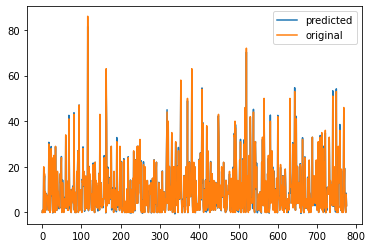

In [32]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_pred, label="predicted")
plt.plot(x_ax, y_test, label="original")
plt.legend()
plt.show()

In [33]:
import matplotlib.pyplot as plt
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
params = {'max_depth' : 4, 'n_estimators' : 100}

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)



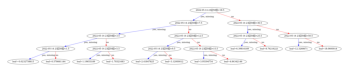

In [34]:
xgb.plot_tree(reg,num_trees=0)
plt.rcParams['figure.figsize'] = [500, 200]
plt.show()

In [35]:
plot_importance(reg, height=0.9)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0, flags=flags)


## LightGBM - 성능이 더 낮은 듯

In [31]:


# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

# laoding data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

# prediction
y_pred = model.predict(X_test)

# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

# visualizing in a plot
# x_ax = range(len(y_test))
# plt.figure(figsize=(12, 6))
# plt.plot(x_ax, y_test, label="original")
# plt.plot(x_ax, y_pred, label="predicted")
# plt.title("Boston dataset test and predicted data")
# plt.xlabel('X')
# plt.ylabel('Price')
# plt.legend(loc='best',fancybox=True, shadow=True)
# plt.grid(True)
# plt.show()  

# # plotting feature importance
# lgb.plot_importance(model, height=0.9) 

[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l2: 110.423	valid_0's l1: 7.82799
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 89.6435	valid_0's l1: 7.03778
[3]	valid_0's l2: 72.9578	valid_0's l1: 6.34179
[4]	valid_0's l2: 59.3789	valid_0's l1: 5.72003
[5]	valid_0's l2: 48.5052	valid_0's l1: 5.16949


/root/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[6]	valid_0's l2: 39.5931	valid_0's l1: 4.66146
[7]	valid_0's l2: 32.4291	valid_0's l1: 4.21487
[8]	valid_0's l2: 26.5615	valid_0's l1: 3.80262
[9]	valid_0's l2: 21.83	valid_0's l1: 3.43248
[10]	valid_0's l2: 17.9494	valid_0's l1: 3.10212
[11]	valid_0's l2: 14.8026	valid_0's l1: 2.80331
[12]	valid_0's l2: 12.2389	valid_0's l1: 2.53417
[13]	valid_0's l2: 10.2941	valid_0's l1: 2.29986
[14]	valid_0's l2: 8.59309	valid_0's l1: 2.08114
[15]	valid_0's l2: 7.22755	valid_0's l1: 1.88836
[16]	valid_0's l2: 6.12873	valid_0's l1: 1.71398
[17]	valid_0's l2: 5.3028	valid_0's l1: 1.56199
[18]	valid_0's l2: 4.59714	valid_0's l1: 1.42531
[19]	valid_0's l2: 4.01309	valid_0's l1: 1.30473
[20]	valid_0's l2: 3.56899	valid_0's l1: 1.19758
[21]	valid_0's l2: 3.20152	valid_0's l1: 1.10292
[22]	valid_0's l2: 2.86597	valid_0's l1: 1.01775
[23]	valid_0's l2: 2.59733	valid_0's l1: 0.945489
[24]	valid_0's l2: 2.39647	valid_0's l1: 0.882034
[25]	valid_0's l2: 2.21791	valid_0's l1: 0.826207
[26]	valid_0's l2: 2.103

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
/root/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0, flags=flags)


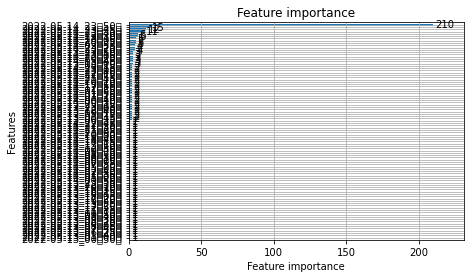

In [32]:
lgb.plot_importance(model, height=0.9) 

In [33]:
# 5분 뒤에 값을 예측한거임 -> 이후에 20분 뒤에를 예측 할 수 있도록 해보자 -> 어떻게 구별하지?
for i in range(100, 500, 20):
    print(str(y_pred[i]),'\t' ,str(y_test[i]), '\n')

1.045961316270436 	 1 

2.0787032480385728 	 2 

4.515845857851941 	 2 

6.014289727088555 	 6 

9.868853442149703 	 10 

1.9430159984155888 	 2 

5.0074511179866565 	 5 

15.196035876183691 	 14 

3.004903304627879 	 3 

1.026750307993074 	 1 

0.22401145134391257 	 0 

14.84208082203581 	 16 

30.50418411806109 	 31 

2.9192196272155835 	 3 

13.812309327085606 	 14 

22.9717416569703 	 23 

20.279774088048168 	 20 

11.975580864423277 	 12 

14.86088415214264 	 15 

1.026750307993074 	 0 



## lstm

In [ ]:
import keras.backend as K 
from keras.callbacks import EarlyStopping
import random
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

K.clear_session()
    
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
model.fit(X, Y, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop])

In [ ]:
random.seed(123)
# create dataset
def CreateTSData(N):
    columns = ['value']
    df = pd.DataFrame(columns=columns)
    for i in range(N):    
        v = i/100+math.sin(2*i)+random.uniform(-1,1)
        df.loc[i]= [v]
    return df

# convert into dataset matrix
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

step=3
N = 240    # total number of rows
Tp = 200     # training part 
df = CreateTSData(N)
df.index=pd.DatetimeIndex(freq="d",start=pd.Timestamp('2000-01-01'),periods=N)
df.head()

values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))
 
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Keras LSTM model 
model = Sequential()
model.add(LSTM(units=32, input_shape=(1,step), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

model.fit(trainX,trainY, epochs=100, batch_size=32, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

index = df.index.values
plt.plot(index,df)
plt.plot(index,predicted)
plt.axvline(df.index[Tp], c="r")
plt.show()

In [ ]:

def create_model():
    model = Sequential()
    
    model.add(LSTM(25, activation='linear', input_shape=(10, 1)))
    model.add(RepeatVector(6))
    model.add(LSTM(25, activation='linear', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    return model



In [ ]:

def do_all_task(args):
    model = create_model()
    
    model.compile(optimizer='adam', loss='mse')
    
    if debug:
        start = time.time()
        history = model.fit(args['x'], args['y'], epochs=300, batch_size=64, verbose=0)
        print("[{:^9}] {:>5}초, loss: {}".format(args['key'], round(time.time() - start, 2), round(history.history['loss'][-1:][0], 4)))
    else:
        model.fit(args['x'], args['y'], epochs=200, batch_size=64, verbose=0)
          
    file_name = 'models/{}.h5'.format(args['key'])
    model.save(file_name)


nCores = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=nCores, maxtasksperchild=8) as pool:
    keys = data.keys()
    result = pool.map(create_dataset, [data[key] for key in keys])

    datasets = {}
    idx = 0
    for key in keys:
        datasets[key] = result[idx]
        idx+=1


with multiprocessing.Pool(processes=nCores) as pool:
    start = time.time()
    print("== 학습 시작 ==")
    
    keys = datasets.keys()
    res = pool.map(do_all_task, [{
        'key': key, 
        'x': datasets[key][0], 
        'y': datasets[key][1]
    } for key in keys])
    
    print("\n")
    print("== 학습 완료 == ")
    print("소요 시간 :", round(time.time() - start, 2))

In [ ]:
Y_train

In [ ]:
lgb_clf = lgb.LGBMClassifier( n_estimators=100, num_leaves=34, learning_rate = 0.1, objective='regression')
lgb_clf.fit(X_train, Y_train)
y_pred = lgb_clf.predict(X_test)
accuracy_score(Y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score


In [ ]:
Y_test

In [ ]:
y_true

In [ ]:
print(y_pred)

In [ ]:
for i in range(20, 80):
    print(Y_test[i],'\t', y_pred[i])

## XG Boost

In [ ]:

XG_model_month = xgb.XGBRegressor(n_estimators=100)
XG_model_month.fit(X_train,Y_train, eval_set=[(X_test, Y_test)], early_stopping_rounds=50,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

In [ ]:
print_clf_eval(Y_test, XG_model_month)

In [ ]:
# #테스트 데이터 중 특정 store/item 데이터를 추출
# df1 = X_test[(X_test.store==1) & (X_test.item==2)]

# xgboost = XG_model_month.predict(df1)

# # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
# result=pd.concat([df_test_orig[(df_test_orig.store==1)&(df_test_orig.item==2)].reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
# result = result.loc[:, ['sales', 'xgboost']]
result.plot()

In [ ]:
# xgb=XGBClassifier(use_label_encoder=False,random_state=42,eval_metric='mlogloss')
# xgb.fit(X_train,Y_train)
# xgb_pred = xgb.predict(X_test)

# print_clf_eval(Y_test, xgb_pred)

# Summary : 성능평가

In [ ]:
# indexs = ['Keras MLP', 'Keras DNN', 'Keras logistic regression', 'Sklearn logistic regression', 'Sklearn Decision Tree', 'Sklearn RandomForest', 'LightGBM','XG Boost']
# columns = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
# temp = []

# temp.append(get_clf_eval(Y_test, model_mlp_pred))
# temp.append(get_clf_eval(Y_test, model_dnn_pred))
# temp.append(get_clf_eval(Y_test, model_log_pred))
# temp.append(get_clf_eval(Y_test, sk_log_pred))
# temp.append(get_clf_eval(Y_test, sk_tree_pred))
# temp.append(get_clf_eval(Y_test, sk_rf_pred))
# temp.append(get_clf_eval(Y_test, lgbm_pred))
# temp.append(get_clf_eval(Y_test, xgb_pred))

# results = pd.DataFrame(temp, index=indexs, columns=columns)
# results.sort_values(by=['F1-score'], axis=0, ascending=False)